In [1]:
import tensorflow as tf
from tensorflow import keras  
import numpy as np
import pandas as pd
from numpy.random import randint
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

at_home = True

if at_home == True:
    checkpoint1_path = 'model_weights_home/cp-{epoch:04d}.ckpt'
    checkpoint2_path = 'binary_model_weights_home/cp-{epoch:04d}.ckpt'
else:
    checkpoint1_path = 'model_weights_uni/cp-{epoch:04d}.ckpt'
    checkpoint2_path = 'binary_model_weights_uni/cp-{epoch:04d}.ckpt'

2023-03-08 02:34:58.100192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 02:34:58.284820: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-08 02:34:58.842449: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/saashiv/miniconda3/envs/tf/lib/
2023-03-08 02:34:58.842656: W tensorflow/compiler/xla/strea

In [2]:
print('image classes')
image_classes = np.loadtxt('labels-map-proj-v3.txt',dtype=str,delimiter=' ')

print('dataframe')
df =pd.DataFrame(image_classes,columns=['filename','class'])

print('shuffling')
df = shuffle(df)

print('traintestsplit')
df,throwaway = train_test_split(df,test_size=0.9)
train_df,test_df = train_test_split(df,test_size=0.2)
train_df,val_df = train_test_split(train_df,test_size=0.5)

print('image generator')
idg = ImageDataGenerator(rescale=1./255.) # normalize
batchsize=128

print('batching')
train_ds = idg.flow_from_dataframe(dataframe=train_df, directory='map-proj-v3',batch_size=batchsize)
test_ds  = idg.flow_from_dataframe(dataframe= test_df, directory='map-proj-v3',batch_size=batchsize)
val_ds =   idg.flow_from_dataframe(dataframe=  val_df, directory='map-proj-v3',batch_size=batchsize)

image classes
dataframe
shuffling
traintestsplit
image generator
batching
Found 2921 validated image filenames belonging to 8 classes.
Found 1461 validated image filenames belonging to 8 classes.
Found 2921 validated image filenames belonging to 8 classes.


In [3]:
print(df)

                                filename class
30378    ESP_014079_1715_RED-0243-fv.jpg     0
68729  ESP_019011_2245_RED-0605-r270.jpg     0
47815    PSP_008932_1645_RED-0162-fv.jpg     0
33984   ESP_025163_1890_RED-0117-brt.jpg     0
9847     ESP_016781_2055_RED-0108-fv.jpg     0
...                                  ...   ...
10306  PSP_006879_2335_RED-0705-r180.jpg     0
30297   ESP_035814_1550_RED-0333-r90.jpg     0
21863  ESP_016570_2050_RED-0132-r180.jpg     0
48918  ESP_028208_1950_RED-0116-r180.jpg     0
56819       ESP_016630_1720_RED-0056.jpg     1

[7303 rows x 2 columns]


2023-03-08 02:35:00.228276: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-08 02:35:00.249293: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-08 02:35:00.249327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-08 02:35:00.249836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other ope

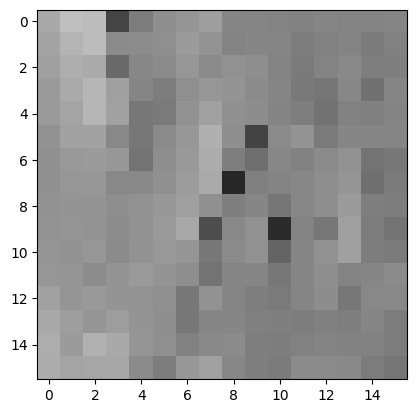

In [4]:
resize = 16
image_test = tf.image.resize(
    train_ds[0][0][0],
    [resize,resize])

plt.imshow(image_test)

In [5]:
BatchSize       = batchsize
Nepochs         = 5
DropoutValue    = 0.6 # currently unused
# set resize in previous cell

zpix = train_ds[0][0][0].shape[2] #colour

input_shape=(0,resize, resize, zpix)

model = keras.models.Sequential()

model.add(keras.layers.Lambda(lambda image:tf.image.resize(image,[resize,resize])))

model.add(keras.layers.Conv2D(8, (3, 3), padding ='same',activation='relu', input_shape=(resize, resize, zpix)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))

#model.add(keras.layers.Conv2D(16, (3, 3), padding='same',activation='relu'))
#model.add(keras.layers.MaxPooling2D((2, 2)))
#model.add(keras.layers.Dropout(0.25))

#model.add(keras.layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
#model.add(keras.layers.MaxPooling2D((2, 2)))
#model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())

#model.add(keras.layers.Dense(16, activation='relu'))
#model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(8, activation='softmax'))

print("--------------------------------------------------------------------------------------------------------------")
print("\033[92mWill train a convolutional neural network on the MNIST data\033[0m")
print("--------------------------------------------------------------------------------------------------------------\n\n")
print("Input data MNIST")
print("Dropout values       = ", DropoutValue)
print("Leaky relu parameter =  0.1")
print("BatchSize            = ", batchsize)
print("Nepochs              = ", Nepochs, "\n")

loss_fn = keras.losses.CategoricalCrossentropy()

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')
checkpoint_path = checkpoint1_path
checkpoint_dir  = os.path.dirname(checkpoint_path)
cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True)

model.build(input_shape) # in week 4 CNN.ipynb Abbey didn't have model.build but her summary works, how?
model.summary()

history  = model.fit(train_ds, validation_data=val_ds,batch_size=batchsize,epochs=Nepochs,callbacks=[tensorboard_callback,cp_callback])

--------------------------------------------------------------------------------------------------------------
Will train a convolutional neural network on the MNIST data
--------------------------------------------------------------------------------------------------------------


Input data MNIST
Dropout values       =  0.6
Leaky relu parameter =  0.1
BatchSize            =  128
Nepochs              =  5 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (0, 16, 16, 3)            0         
                                                                 
 conv2d (Conv2D)             (0, 16, 16, 8)            224       
                                                                 
 max_pooling2d (MaxPooling2D  (0, 8, 8, 8)             0         
 )                                                               
                                       

2023-03-08 02:35:03.872052: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-08 02:35:05.344910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-08 02:35:07.048962: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-08 02:35:07.765586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-08 02:35:07.768429: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f92d285c8b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-08 02:35:07.768458: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor devi

23/23 [==============================] - ETA: 0s - loss: 1.0674 - accuracy: 0.7689
Epoch 1: saving model to model_weights_home/cp-0001.ckpt
23/23 [==============================] - 9s 194ms/step - loss: 1.0674 - accuracy: 0.7689 - val_loss: 0.8463 - val_accuracy: 0.8384
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 0.8117 - accuracy: 0.8401
Epoch 2: saving model to model_weights_home/cp-0002.ckpt
23/23 [==============================] - 3s 147ms/step - loss: 0.8117 - accuracy: 0.8401 - val_loss: 0.7643 - val_accuracy: 0.8384
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 0.7651 - accuracy: 0.8401
Epoch 3: saving model to model_weights_home/cp-0003.ckpt
23/23 [==============================] - 3s 140ms/step - loss: 0.7651 - accuracy: 0.8401 - val_loss: 0.7455 - val_accuracy: 0.8384
Epoch 4/5
23/23 [==============================] - ETA: 0s - loss: 0.7456 - accuracy: 0.8401
Epoch 4: saving model to model_weights_home/cp-0004.ckpt
23/23 [==========

In [6]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)
loss, acc = model.evaluate(test_ds)

12/12 [==============================] - 1s 93ms/step - loss: 0.6867 - accuracy: 0.8467


history keys =  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Display the evolution of the accuracy as a function of the training epoch
  N(Epochs)        =  5
  accuracy (train) =  [0.7689147591590881, 0.8401232361793518, 0.8401232361793518, 0.8401232361793518, 0.8401232361793518]
  accuracy (test)  =  [0.8384115099906921, 0.8384115099906921, 0.8384115099906921, 0.8384115099906921, 0.8384115099906921]

Display the evolution of the loss as a function of the training epoch
  N(Epochs)        =  5
  loss (train)     =  [1.0673565864562988, 0.8116792440414429, 0.7651275396347046, 0.74562007188797, 0.7182571291923523]


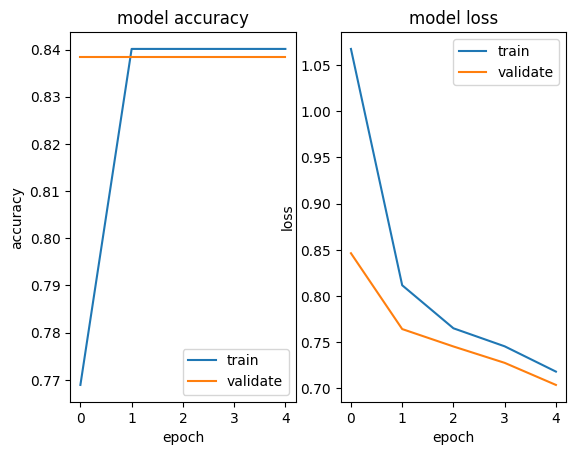

In [7]:
# Print out the history keys expected are:
#    loss        The loss function evaluated at each epoch for the training set
#    acc         The accuracy evaluated at each epoch for the training set
#    val_loss    The loss evaluated at each epoch for the validation set
#    val_acc     The accuracy evaluated at each epoch for the validation set
# The val_* entries exist only if there is a validation_split specified

print("history keys = ", history.history.keys())

print("\n\033[1mDisplay the evolution of the accuracy as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)

print("  accuracy (train) = ", history.history['accuracy'])
print("  accuracy (test)  = ", history.history['val_accuracy'])
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

print("\n\033[1mDisplay the evolution of the loss as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)
print("  loss (train)     = ", history.history['loss'])
#print("  loss (test)      = ", history.history['val_loss'])

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [8]:
predictions = model.predict(test_ds)

12/12 [==============================] - 1s 73ms/step


In [9]:
import csv

# Create an empty dictionary to store the data
data_dict = {}

with open('landmarks_map-proj-v3_classmap.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # Get the number and word values from the current row
        num = int(row[0])
        word = row[1]
        # Add the values to the dictionary
        data_dict[num] = word

In [10]:
print(data_dict[4])

bright dune


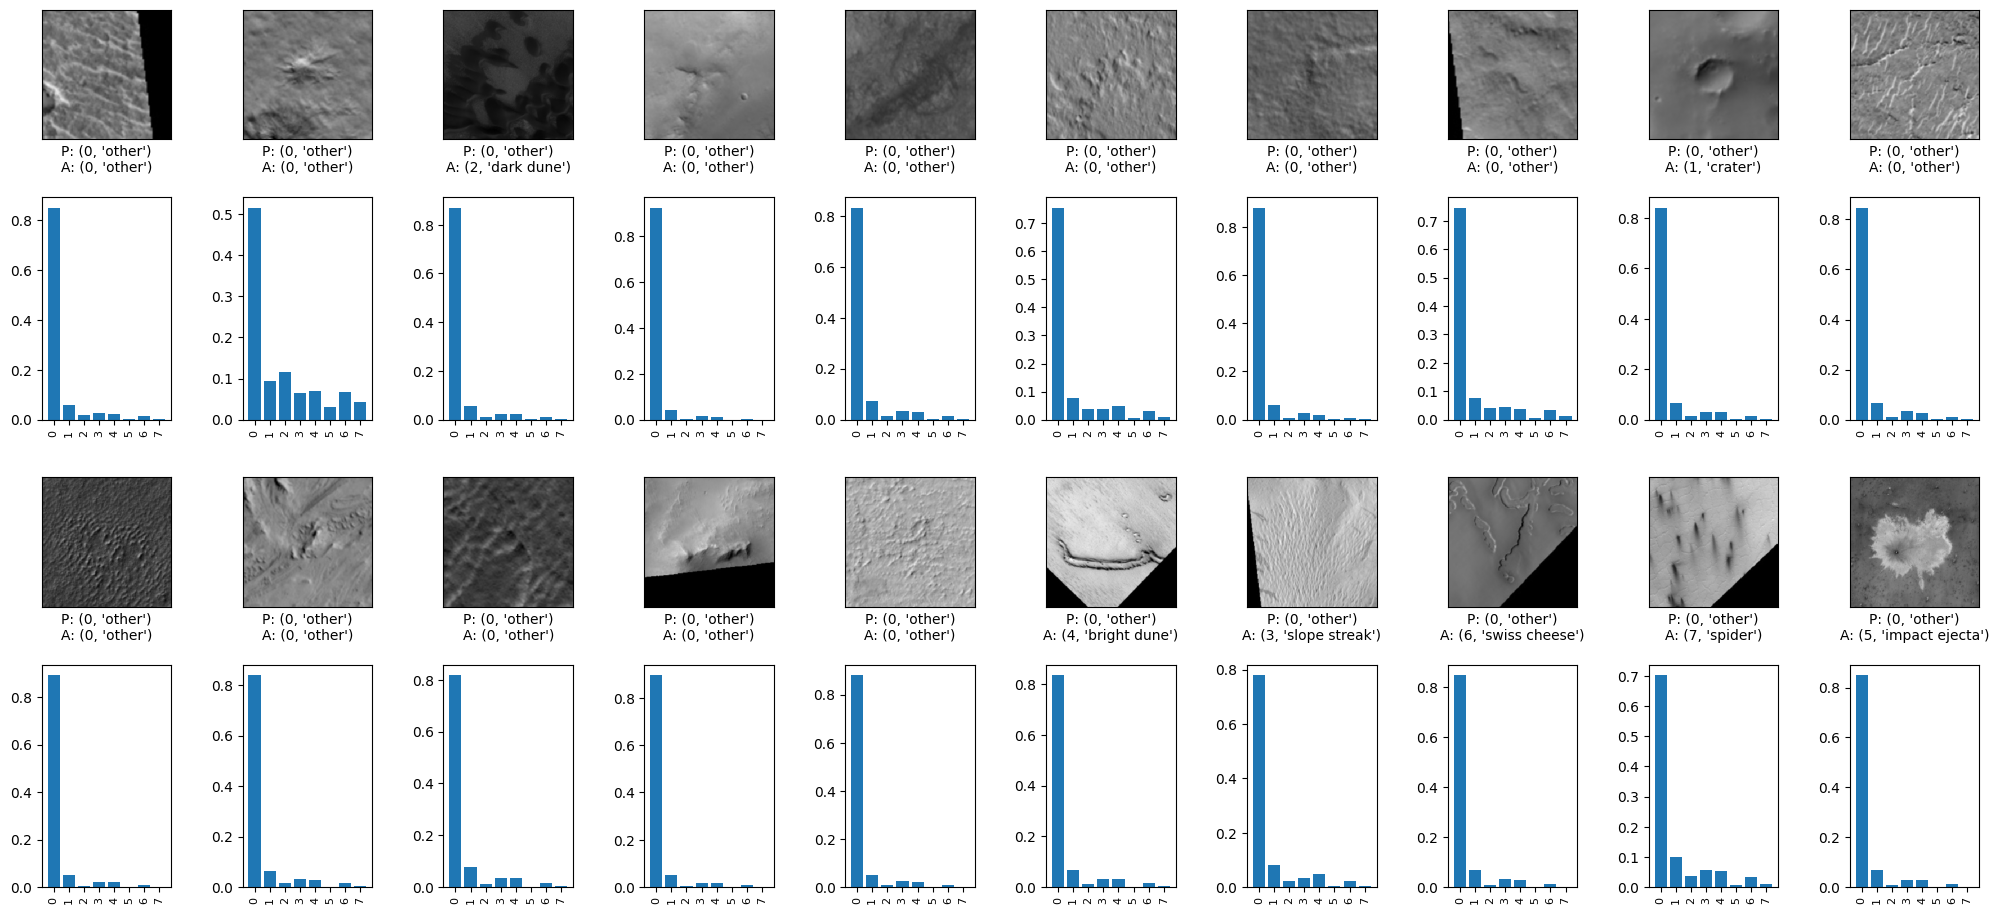

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(25, 12))
class_list = [i for i in range(0,8)]

rand_list = list(randint(0,1,12))
for i in rand_list:
    class_list.append(i)
count = 0
j = 0
x,y = 0,1
image_count = 0
for i in test_ds:
    image_count = 0
    for k in i[1]:
        prediction = predictions[count]
        actual = np.argmax(k)
        if np.isin(actual,class_list):

            axes[x][j].imshow(i[0][image_count])
            axes[x][j].set_xticks([])
            axes[x][j].set_yticks([])

            # Set the x axis label
            axes[x][j].set_xlabel(f"P: {np.argmax(prediction),data_dict[int(np.argmax(prediction))]}\nA: {actual, data_dict[actual]}",fontsize=10)

            # Add some space between subplots
            plt.subplots_adjust(wspace=0.55)
            plt.subplots_adjust(hspace=0.05)

            # Plot the predicted probabilities as a bar graph
            axes[y][j].bar([0,1,2,3,4,5,6,7],prediction)
            axes[y][j].set_xticks([0,1,2,3,4,5,6,7])
            axes[y][j].set_xticklabels([0,1,2,3,4,5,6,7], rotation=90, fontsize=8)

            class_list.remove(int(actual))

            j += 1
    
        image_count += 1
        count += 1

        if len(class_list) == 10:
            x,y,j=2,3,0
        if class_list == []:
            break
    if class_list == []:
        break

In [12]:
abs_predictions = np.argmax(predictions,axis=1)
test_df['models class'] = abs_predictions
test_df.head(20)
print(len(abs_predictions))

1461


[100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Text(0, 0.5, 'prediction accuracy')

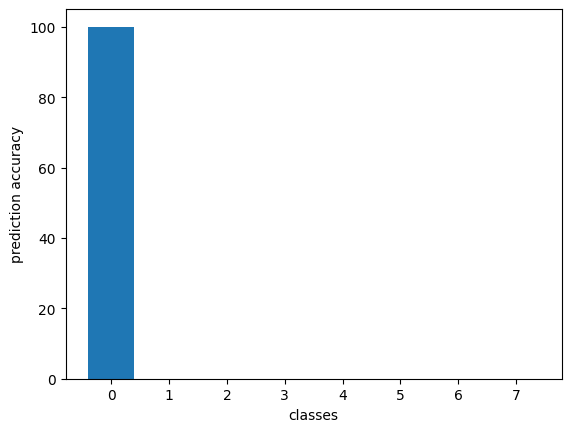

In [13]:
# for some reason class was a column of strings... took ages to figure that out
test_df['class'] = test_df['class'].astype(int)
class_list = [i for i in range(0,8)]

accuracy_list = []
for i in class_list:
    
    df_0 = test_df.loc[test_df['class'] == i]
    num_identical = sum(df_0['class'] == df_0['models class'])
    num_rows = len(df_0)
    percent_identical = num_identical / num_rows * 100
    accuracy_list.append(percent_identical)

print(accuracy_list)
plt.bar(class_list,accuracy_list)
plt.xlabel('classes')
plt.ylabel('prediction accuracy')

### changing to is/is not:[dune]

In [14]:
import csv

# Create an empty dictionary to store the data
data_dict = {}

with open('landmarks_map-proj-v3_classmap_DUNES.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # Get the number and word values from the current row
        num = int(row[0])
        word = row[1]
        # Add the values to the dictionary
        data_dict[num] = word

In [15]:
print('image classes')
image_classes = np.loadtxt('labels-map-proj-v3.txt',dtype=str,delimiter=' ')

print('dataframe')
df =pd.DataFrame(image_classes,columns=['filename','class'])

print('shuffling')
df = shuffle(df)

# Replace non-dune class labels with 0 & again with the string values for class. whyyyyyyyyyyy
df['class'] = df['class'].astype(int)
df.loc[~df['class'].isin([2, 4]), 'class'] = 0
df['class'] = df['class'].astype(str)

print('traintestsplit')
df,throwaway = train_test_split(df,test_size=0.9)
train_df,test_df = train_test_split(df,test_size=0.2)
train_df,val_df = train_test_split(train_df,test_size=0.5)

print('image generator')
idg = ImageDataGenerator(rescale=1./255.) # normalize
batchsize= 128
resize = 64
# and now the classes have to be strings again... whhhhhhhhhhhhhhhhhhyyyyyyyyyyyyyyyy
print('batching')
train_ds = idg.flow_from_dataframe(dataframe=train_df, directory='map-proj-v3',batch_size=batchsize)
test_ds  = idg.flow_from_dataframe(dataframe= test_df, directory='map-proj-v3',batch_size=batchsize)
val_ds =   idg.flow_from_dataframe(dataframe=  val_df, directory='map-proj-v3',batch_size=batchsize)

image classes
dataframe
shuffling
traintestsplit
image generator
batching
Found 2921 validated image filenames belonging to 3 classes.
Found 1461 validated image filenames belonging to 3 classes.
Found 2921 validated image filenames belonging to 3 classes.


In [16]:
BatchSize       = batchsize
Nepochs         = 5
DropoutValue    = 0.6 # currently unused
# set resize in previous cell

zpix = train_ds[0][0][0].shape[2] #colour

input_shape=(0,resize, resize, zpix)

model = keras.models.Sequential()

model.add(keras.layers.Lambda(lambda image:tf.image.resize(image,[resize,resize])))

model.add(keras.layers.Conv2D(8, (3, 3), padding ='same',activation='relu', input_shape=(resize, resize, zpix)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(16, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(63, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

print("--------------------------------------------------------------------------------------------------------------")
print("\033[92mWill train a convolutional neural network on the MNIST data\033[0m")
print("--------------------------------------------------------------------------------------------------------------\n\n")
print("Input data MNIST")
print("Dropout values       = ", DropoutValue)
print("Leaky relu parameter =  0.1")
print("BatchSize            = ", batchsize)
print("Nepochs              = ", Nepochs, "\n")


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')
checkpoint_path = checkpoint2_path
checkpoint_dir  = os.path.dirname(checkpoint_path)
cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True)

model.build(input_shape) # in week 4 CNN.ipynb Abbey didn't have model.build but her summary works, how?

## HOW CAN IT TEST FOR LOSS WITHOUT A THRESHOLD IS IT SENTIENT???

model.summary()

history  = model.fit(train_ds, validation_data=val_ds,batch_size=batchsize,epochs=Nepochs,callbacks=[tensorboard_callback,cp_callback])

--------------------------------------------------------------------------------------------------------------
Will train a convolutional neural network on the MNIST data
--------------------------------------------------------------------------------------------------------------


Input data MNIST
Dropout values       =  0.6
Leaky relu parameter =  0.1
BatchSize            =  128
Nepochs              =  5 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (0, 64, 64, 3)            0         
                                                                 
 conv2d_1 (Conv2D)           (0, 64, 64, 8)            224       
                                                                 
 max_pooling2d_1 (MaxPooling  (0, 32, 32, 8)           0         
 2D)                                                             
                                     

history keys =  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Display the evolution of the accuracy as a function of the training epoch
  N(Epochs)        =  5
  accuracy (train) =  [0.6666667461395264, 0.6666667461395264, 0.6666667461395264, 0.6666667461395264, 0.6666667461395264]
  accuracy (test)  =  [0.6666667461395264, 0.6666667461395264, 0.6666667461395264, 0.6666667461395264, 0.6666667461395264]

Display the evolution of the loss as a function of the training epoch
  N(Epochs)        =  5
  loss (train)     =  [0.6413763165473938, 0.6371192336082458, 0.636620819568634, 0.6365504860877991, 0.6365333795547485]


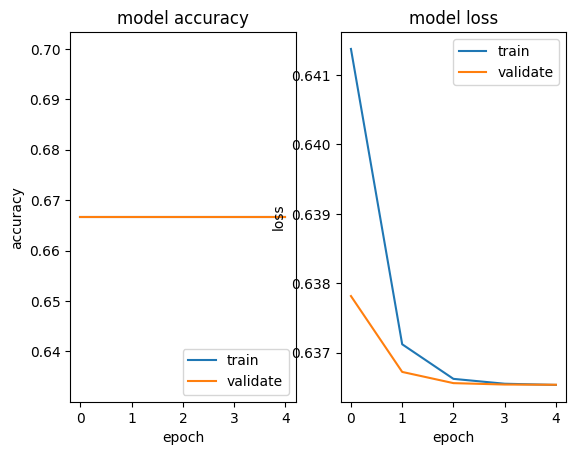

In [17]:
# Print out the history keys expected are:
#    loss        The loss function evaluated at each epoch for the training set
#    acc         The accuracy evaluated at each epoch for the training set
#    val_loss    The loss evaluated at each epoch for the validation set
#    val_acc     The accuracy evaluated at each epoch for the validation set
# The val_* entries exist only if there is a validation_split specified

print("history keys = ", history.history.keys())

print("\n\033[1mDisplay the evolution of the accuracy as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)

print("  accuracy (train) = ", history.history['accuracy'])
print("  accuracy (test)  = ", history.history['val_accuracy'])
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

print("\n\033[1mDisplay the evolution of the loss as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)
print("  loss (train)     = ", history.history['loss'])
#print("  loss (test)      = ", history.history['val_loss'])

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [18]:
predictions = model.predict(test_ds)

12/12 [==============================] - 1s 109ms/step


In [19]:
print(predictions)

[[0.33136505]
 [0.32602733]
 [0.3318267 ]
 ...
 [0.3319141 ]
 [0.33478037]
 [0.33028743]]


In [20]:
predictions = np.where(predictions >= np.mean(predictions), 1, 0)
#predictions = np.where(predictions >=0.334, 1, 0)

In [21]:
print(predictions)

[[0]
 [0]
 [1]
 ...
 [1]
 [1]
 [0]]


In [22]:
print(test_df)
print(test_df[test_df['class']=='2'])
print(test_df[test_df['class']=='4'])

                                filename class
18357  ESP_017541_1600_RED-0381-r270.jpg     0
29657    ESP_011677_1655_RED-0256-fv.jpg     0
4289     ESP_011289_1950_RED-0138-fv.jpg     0
67924  ESP_028196_1840_RED-0340-r270.jpg     0
22320    PSP_005150_1490_RED-0112-fh.jpg     0
...                                  ...   ...
23797    ESP_028196_1840_RED-0375-fh.jpg     0
38657  ESP_025050_1680_RED-0191-r270.jpg     0
33412   ESP_012700_2025_RED-0091-r90.jpg     0
65793       ESP_016758_2570_RED-0042.jpg     4
15114   ESP_018192_1985_RED-0197-r90.jpg     0

[1461 rows x 2 columns]
                                filename class
6655     ESP_018720_2655_RED-0126-fv.jpg     2
55895       ESP_018720_2655_RED-0064.jpg     2
35699   ESP_018720_2655_RED-0017-brt.jpg     2
59751   ESP_018321_2565_RED-0023-brt.jpg     2
43575       ESP_018720_2655_RED-0031.jpg     2
59210    ESP_014429_1940_RED-0031-fh.jpg     2
10752       ESP_018720_2655_RED-0105.jpg     2
4324     ESP_018720_2655_RED-0027-f

In [23]:
test_df.loc[test_df['class'].isin(['2', '4']), 'class'] = 1
test_df.loc[test_df['class'].isin(['0']), 'class'] = 0

In [24]:
print(test_df[test_df['class']==0])
print(test_df[test_df['class']==1])

                                filename class
18357  ESP_017541_1600_RED-0381-r270.jpg     0
29657    ESP_011677_1655_RED-0256-fv.jpg     0
4289     ESP_011289_1950_RED-0138-fv.jpg     0
67924  ESP_028196_1840_RED-0340-r270.jpg     0
22320    PSP_005150_1490_RED-0112-fh.jpg     0
...                                  ...   ...
11969   ESP_018192_1985_RED-0083-brt.jpg     0
23797    ESP_028196_1840_RED-0375-fh.jpg     0
38657  ESP_025050_1680_RED-0191-r270.jpg     0
33412   ESP_012700_2025_RED-0091-r90.jpg     0
15114   ESP_018192_1985_RED-0197-r90.jpg     0

[1402 rows x 2 columns]
                                filename class
69772  ESP_016683_2535_RED-0075-r270.jpg     1
67200       ESP_016631_2535_RED-0051.jpg     1
47615   ESP_016631_2535_RED-0018-r90.jpg     1
6655     ESP_018720_2655_RED-0126-fv.jpg     1
55895       ESP_018720_2655_RED-0064.jpg     1
35699   ESP_018720_2655_RED-0017-brt.jpg     1
49128  ESP_016631_2535_RED-0050-r180.jpg     1
37721    ESP_016758_2570_RED-0002-f

In [25]:
test_df['class'] = test_df['class'].astype(bool)

In [26]:
print(test_df[test_df['class']==True])
print(test_df[test_df['class']==False])

                                filename  class
69772  ESP_016683_2535_RED-0075-r270.jpg   True
67200       ESP_016631_2535_RED-0051.jpg   True
47615   ESP_016631_2535_RED-0018-r90.jpg   True
6655     ESP_018720_2655_RED-0126-fv.jpg   True
55895       ESP_018720_2655_RED-0064.jpg   True
35699   ESP_018720_2655_RED-0017-brt.jpg   True
49128  ESP_016631_2535_RED-0050-r180.jpg   True
37721    ESP_016758_2570_RED-0002-fv.jpg   True
10838  ESP_016576_2570_RED-0016-r180.jpg   True
59751   ESP_018321_2565_RED-0023-brt.jpg   True
43575       ESP_018720_2655_RED-0031.jpg   True
10485   ESP_016631_2535_RED-0116-brt.jpg   True
59210    ESP_014429_1940_RED-0031-fh.jpg   True
10752       ESP_018720_2655_RED-0105.jpg   True
24996   ESP_016758_2570_RED-0019-brt.jpg   True
65796  ESP_016758_2570_RED-0042-r270.jpg   True
20246  ESP_016576_2570_RED-0019-r180.jpg   True
4324     ESP_018720_2655_RED-0027-fv.jpg   True
33970   ESP_016631_2535_RED-0138-brt.jpg   True
15207  ESP_016683_2535_RED-0009-r270.jpg

In [27]:
my_classlist = test_df['class'].to_numpy()

In [28]:
bool_pred = []
for i in predictions:
    bool_pred.append(bool(i))
bool_pred = np.array(bool_pred)

In [29]:
print(bool_pred)

[False False  True ...  True  True False]


In [30]:
fpr, tpr, _ = roc_curve(my_classlist, predictions)
roc_auc = auc(fpr, tpr)

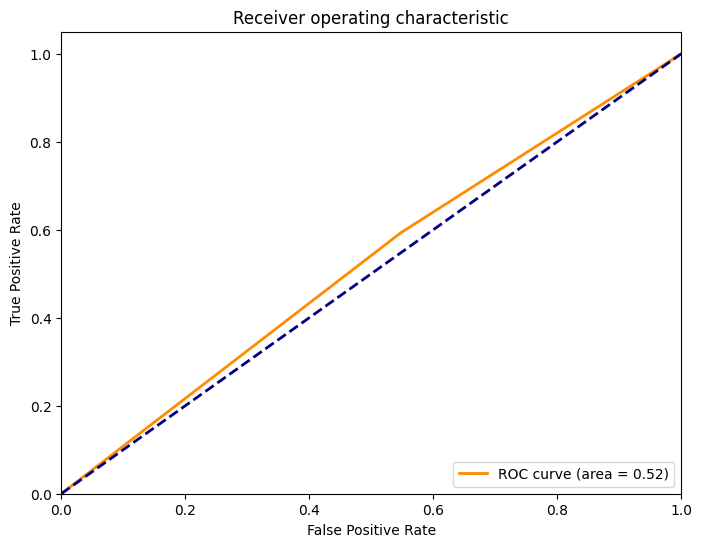

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
